### 0. Импорт библиотек.Объявление вспомогательных функций.  Общий обзор имееющихся данных об отелях

По итогам этого пункта стало понятно, что предварительно необходимо  
заполнить пропуски и преобразовать текстовые поля.  
1. Столбцы с пропущенными значениями:\
lat    2448\
lng    2448\
dtype: int64
2. Текстовые колонки:  
[   'hotel_address' ,  
    'review_date',  
    'hotel_name',  
    'reviewer_nationality',  
    'positive_review',  
    'negative_review',  
    'tags',  
    'days_since_review']

In [360]:
import pandas as pd
import pprint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import category_encoders as ce
import regex as re
from sklearn import preprocessing # для нормализации, стандартизации

warnings.filterwarnings("ignore")
pp = pprint.PrettyPrinter(indent=4)
INPUT_DIR = 'data/'

In [361]:
#Функция для отображения процентов на plt.pie
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

In [362]:
#Загружаем датасеты, запоминаем их размеры
hotels_train = pd.read_csv(INPUT_DIR+'hotels_train.csv')
hotels_test = pd.read_csv(INPUT_DIR+'hotels_test.csv')
y = hotels_train['reviewer_score']
hotels_train.drop(columns=['reviewer_score'],inplace=True)

hotels = pd.concat([hotels_train,hotels_test])
train_size = hotels_train.shape[0]
test_size = hotels_test.shape[0]
hotels.head()


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


In [363]:
print('Столбцы с пропущенными значениями:')
print(hotels.isnull().sum()[hotels.isnull().sum()>0])
print()
print('Текстовые колонки и пример данных в них:')
text_columns = list(hotels.select_dtypes(['object']).columns)
pp.pprint(dict(hotels[text_columns].head(1).squeeze()))

Столбцы с пропущенными значениями:
lat    3268
lng    3268
dtype: int64

Текстовые колонки и пример данных в них:
{   'days_since_review': '531 day',
    'hotel_address': 'Stratton Street Mayfair Westminster Borough London W1J '
                     '8LT United Kingdom',
    'hotel_name': 'The May Fair Hotel',
    'negative_review': ' Leaving ',
    'positive_review': ' Staff were amazing',
    'review_date': '2/19/2016',
    'reviewer_nationality': ' United Kingdom ',
    'tags': "[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 "
            "nights ', ' Submitted from a mobile device ']"}


In [364]:
print('Число уникальных значений в текстовых столбцах.')
print()
print('Cтолбец: Число')
for col in text_columns:
    print(col,': ',hotels[col].nunique())

Число уникальных значений в текстовых столбцах.

Cтолбец: Число
hotel_address :  1493
review_date :  731
hotel_name :  1492
reviewer_nationality :  227
negative_review :  330011
positive_review :  412601
tags :  55242
days_since_review :  731


### 1. Заполнение пропусков. Колонки lat и lng.
Тут создадим список из координат отелей, для которых они не заполнены.  
Так как таких отелей немного(17 штук), этот список несложно заполнить вручную.

In [365]:
#Считаем число отелей с пропущенными координатами
hotels_with_missed_coordinates_filter = (hotels['lat'].isnull() | hotels['lng'].isnull())
print('Число уникальных отелей с пропущенными координатами:'
      ,hotels[hotels_with_missed_coordinates_filter]['hotel_name'].nunique())

Число уникальных отелей с пропущенными координатами: 17


In [366]:
#Создадим словарь из названия отеля и его координат
missed_coordinates = {'Austria Trend Hotel Schloss Wilhelminenberg Wien': {'lat': 48.21971233863911, 'lng': 16.285559911370925},
     'City Hotel Deutschmeister': {'lat': 48.22557562151795, 'lng': 16.3569080164676},
     'Cordial Theaterhotel Wien': {'lat': 48.20979381702941, 'lng': 16.351405869041535},
     'Derag Livinghotel Kaiser Franz Joseph Vienna': {'lat': 48.2460301651288, 'lng': 16.341821609523205},
     'Fleming s Selection Hotel Wien City': {'lat': 48.20977856683548, 'lng': 16.353289782534986},
     'Holiday Inn Paris Montmartre': {'lat': 48.88941259668721, 'lng': 2.3331310587211367},
     'Hotel Advance': {'lat': 41.38339141898337, 'lng': 2.1629817841319},
     'Hotel Atlanta': {'lat': 48.220354950512025, 'lng': 16.35579826904204},
     'Hotel City Central': {'lat': 48.2137089046276, 'lng': 16.380143313219502},
     'Hotel Daniel Vienna': {'lat': 48.20125216724915, 'lng': 16.396178055241602},
     'Hotel Park Villa': {'lat': 48.21461896267337, 'lng': 16.37524539166694},
     'Hotel Pension Baron am Schottentor': {'lat': 48.22517535734479, 'lng': 16.356693439756796},
     'Maison Albar Hotel Paris Op ra Diamond': {'lat': 48.8569023786901, 'lng': 2.30474305557366},
     'Mercure Paris Gare Montparnasse': {'lat': 48.85183565438709, 'lng': 2.3027929567768903},
     'NH Collection Barcelona Podium': {'lat': 41.38978236701589, 'lng': 2.1640239924788114},
     'Renaissance Barcelona Hotel': {'lat': 41.38830040033557, 'lng': 2.1639810754051885},
     'Roomz Vienna': {'lat': 48.17020563584927, 'lng': 16.421800566874175}}

#Функция для заполнения пропущенных координат по названию отеля
def set_hotel_lat_lng(row):
    hotel_name = row['hotel_name']
    row['lat'] = missed_coordinates[hotel_name]['lat']
    row['lng'] = missed_coordinates[hotel_name]['lng']
    return row

hotels[hotels_with_missed_coordinates_filter] =\
    hotels[hotels_with_missed_coordinates_filter].apply(set_hotel_lat_lng,axis = 1)

### 2. Преобразование текстовых столбцов.

#### 2.1 hotel_address
- Из этой колонки достанем название города;  
- Построим распределение отзывов по городам,  на котором  
будет видно, что большинство отзывов оставлено по отелям Лондона, а всего городов 6;  
- С помощью onehotencoding преобразуем признак city;

[Text(0.5, 1.0, 'Распределение данных по городам в %')]

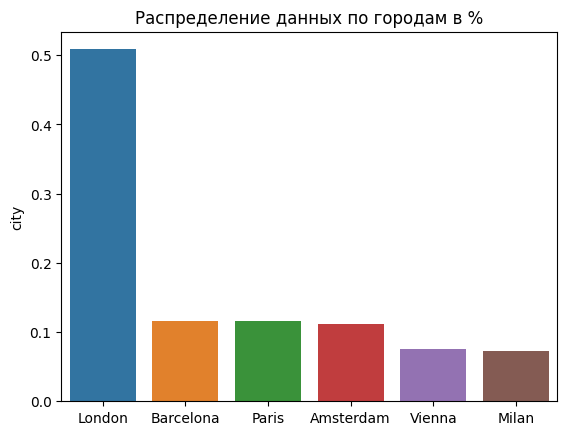

In [367]:
#Достаем город из адреса
def get_city(value):
    if 'United Kingdom' in value:
        city = value.split()[-5]
    else:
        city = value.split()[-2]
    return city
hotels['city'] = hotels['hotel_address'].apply(get_city)
city_value_counts = hotels['city'].value_counts()/hotels.shape[0]

#Строим график распределения отелей по городам
sns.barplot(x = city_value_counts.index,y = city_value_counts)\
            .set(title = 'Распределение данных по городам в %')

In [368]:
hotels = pd.get_dummies(hotels, columns=['city'])
hotels.filter(like='city_').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 128934
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   city_Amsterdam  515738 non-null  uint8
 1   city_Barcelona  515738 non-null  uint8
 2   city_London     515738 non-null  uint8
 3   city_Milan      515738 non-null  uint8
 4   city_Paris      515738 non-null  uint8
 5   city_Vienna     515738 non-null  uint8
dtypes: uint8(6)
memory usage: 6.9 MB


#### 2.2 review_date
- Из этого признака получим сезон, когда был оставлен отзыв;  
- Построим распределение по сезонам, на котором увидим   
что примерно одинаковое число отзывов оставлялось в каждом сезоне,  
однако летом отзывов немного больше;    
- С помощью onehotencoding преобразуем признак season.

[Text(0.5, 1.0, 'Распределение данных по сезонам в %')]

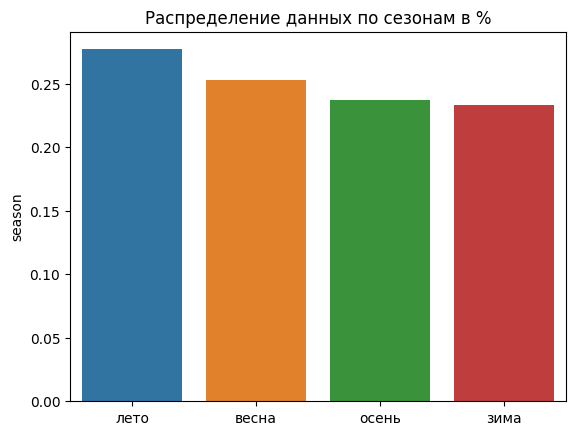

In [369]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
# Создадим признак - сезон заполнения отзыва
# 1 - зима, 2 - весна, 3 - лето, 4 - осень
hotels['season'] = hotels['review_date'].dt.month%12//3+1
season_value_counts = hotels['season'].value_counts()/hotels.shape[0]
season_value_counts.rename({1:'зима',2:'весна',3:'лето',4:'осень'},inplace=True)

#Строим график распределения отелей по городам
sns.barplot(x = season_value_counts.index,y = season_value_counts)\
            .set(title = 'Распределение данных по сезонам в %')

In [370]:
# hotels = pd.get_dummies(hotels, columns=['season'])
# hotels.filter(like='season_').head()
# hotels['year'] = hotels['review_date'].dt.year
# hotels = pd.get_dummies(hotels, columns=['year'])


In [371]:
hotels.filter(like='year_').head()

""
0
1
2
3
4


#### 2.3 hotel_name
- Полагаем, что полезной информации из имени отеля не получим  
и удаляем этот признак.

In [372]:
hotels.drop('hotel_name',axis=1,inplace=True)

#### 2.4 reviewer_nationality
- Всего уникальных национальностей 225;  
- Почти в половине отзывов национальность united kingdom;  
- Для кодировки признака используем binary encoding.

In [373]:
print('Число уникальных национальностей: ',hotels['reviewer_nationality'].nunique())

Число уникальных национальностей:  227


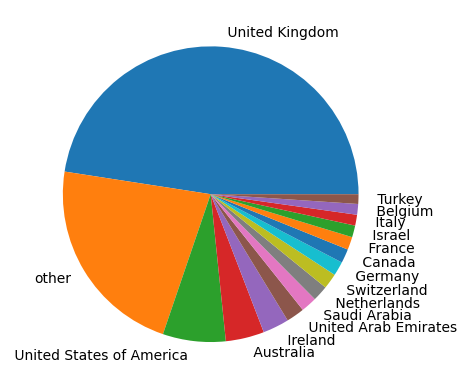

In [374]:
# Строим пирог распределения национальности 
# при этом национальности , которые не входят в топ 12, помечаем как 'other'
top_nationalities = hotels['reviewer_nationality'].value_counts().head(15).index
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(
    lambda x: x if x in top_nationalities else 'other')
reviewer_nationality_pie_data = hotels['reviewer_nationality'].value_counts()
plt.pie(x= reviewer_nationality_pie_data, labels=reviewer_nationality_pie_data.index);

In [375]:
#Кодируем признак национальности с помощью двоичного кодирования
# bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
# reviewer_nationality_bin = bin_encoder.fit_transform(hotels['reviewer_nationality'])
# hotels = pd.concat([hotels, reviewer_nationality_bin], axis=1)
# hotels.drop('reviewer_nationality',axis=1,inplace=True)
hotels = pd.get_dummies(hotels, columns=['reviewer_nationality'])
hotels.filter(like='reviewer_nationality').head()

,reviewer_nationality_ Australia,reviewer_nationality_ Belgium,reviewer_nationality_ Canada,reviewer_nationality_ France,reviewer_nationality_ Germany,reviewer_nationality_ Ireland,reviewer_nationality_ Israel,reviewer_nationality_ Italy,reviewer_nationality_ Netherlands,reviewer_nationality_ Saudi Arabia,reviewer_nationality_ Switzerland,reviewer_nationality_ Turkey,reviewer_nationality_ United Arab Emirates,reviewer_nationality_ United Kingdom,reviewer_nationality_ United States of America,reviewer_nationality_other
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


#### 2.5 positive_review и negative_review
- Ищем самые часто употребляемые слова в этих признаках и  
на основе этого делаем признак

In [376]:
# hotels.drop(columns=['positive_review','positive_review'],axis=1,inplace=True)
hotels['positive_review']  = hotels['positive_review'].apply(lambda x: x.lower())
hotels['negative_review']  = hotels['negative_review'].apply(lambda x: x.lower())

In [377]:
#Создаем словарь слов в позитивных отзывах
def get_dict(text,dict):
    for word in text.split():
        if word not in dict.keys():
            dict[word] = 1
        else:
            dict[word] += 1
pos_dict = {}
hotels['positive_review'].apply(lambda x:get_dict(x,pos_dict));
pos_dict = dict(sorted(pos_dict.items(), key=lambda item: item[1],reverse=True))

<Axes: >

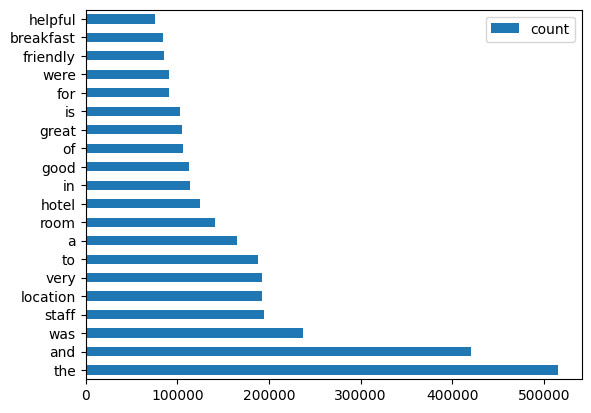

In [378]:
#По частоте самых использумемых слов выберем самые частые не общие слова
#то есть, например не берем слово the, но берем staff
pos_words_df = pd.DataFrame(pos_dict,index=['count']).transpose()
pos_words_df[:20].plot(kind='barh')

<Axes: >

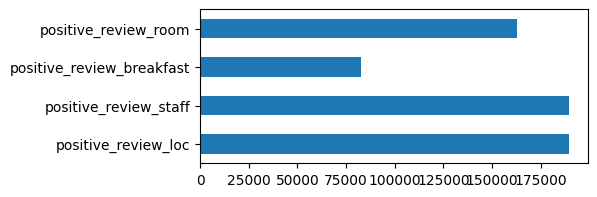

In [379]:
hotels['positive_review_loc'] = hotels['positive_review'].apply(lambda x: 1 if 'location' in x else 0)
hotels['positive_review_staff'] = hotels['positive_review'].apply(lambda x: 1 if 'staff' in x else 0)
hotels['positive_review_breakfast'] = hotels['positive_review'].apply(lambda x: 1 if 'breakfast' in x else 0)
hotels['positive_review_room'] = hotels['positive_review'].apply(lambda x: 1 if 'room' in x else 0)

hotels.filter(like='positive_review_').sum().plot(kind='barh',figsize=(5,2))

In [380]:
#Создаем словарь слов в негативных отзывах
def get_dict(text,dict):
    for word in text.split():
        if word not in dict.keys():
            dict[word] = 1
        else:
            dict[word] += 1
neg_dict = {}
hotels['negative_review'].apply(lambda x:get_dict(x,neg_dict));
neg_dict = dict(sorted(neg_dict.items(), key=lambda item: item[1],reverse=True))

<Axes: >

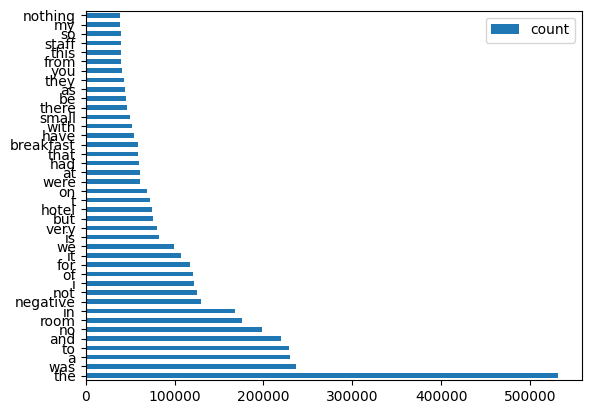

In [381]:
neg_words_df = pd.DataFrame(neg_dict,index=['count']).transpose()
neg_words_df[:40].plot(kind='barh')

<Axes: >

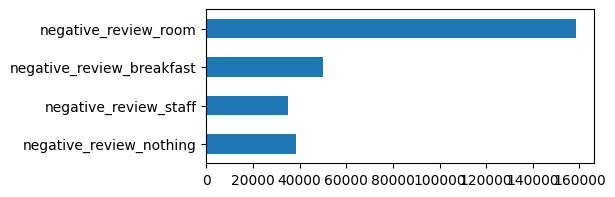

In [382]:
hotels['negative_review_nothing'] = hotels['negative_review'].apply(lambda x: 1 if 'nothing' in x else 0)
hotels['negative_review_staff'] = hotels['negative_review'].apply(lambda x: 1 if 'staff' in x else 0)
hotels['negative_review_breakfast'] = hotels['negative_review'].apply(lambda x: 1 if 'breakfast' in x else 0)
hotels['negative_review_room'] = hotels['negative_review'].apply(lambda x: 1 if 'room' in x else 0)

hotels.filter(like='negative_review_').sum().plot(kind='barh',figsize=(5,2))

#### 2.6 tags
Тут посмотрим какие таги есть, и по некоторым создадим  
новые признаки. Таги запишем в tag_dict

In [383]:
tag_dict = dict()
def count_tags(tags):
    for tag in tags.replace('[\' ','').replace(' \']','').split(" ', ' "):
        if tag not in tag_dict.keys():
            tag_dict[tag] = 1
        else:
            tag_dict[tag] += 1 
    

In [384]:
hotels['tags'].apply(count_tags);
print('Число уникальных тегов: ',len(tag_dict))

Число уникальных тегов:  2428


In [385]:
tag_dict_sorted_by_count = (sorted(tag_dict.items(),key=lambda x:x[1],reverse=True))
print('Самый популярный таг: ',tag_dict_sorted_by_count[0])

Самый популярный таг:  ('Leisure trip', 417778)


In [386]:
print('Топ самых популярных тагов')
tag_dict_sorted_by_count[:20]

Топ самых популярных тагов


[('Leisure trip', 417778),
 ('Submitted from a mobile device', 307640),
 ('Couple', 252294),
 ('Stayed 1 night', 193645),
 ('Stayed 2 nights', 133937),
 ('Solo traveler', 108545),
 ('Stayed 3 nights', 95821),
 ('Business trip', 82939),
 ('Group', 65392),
 ('Family with young children', 61015),
 ('Stayed 4 nights', 47817),
 ('Double Room', 35207),
 ('Standard Double Room', 32248),
 ('Superior Double Room', 31393),
 ('Family with older children', 26349),
 ('Deluxe Double Room', 24823),
 ('Double or Twin Room', 22393),
 ('Stayed 5 nights', 20845),
 ('Standard Double or Twin Room', 17483),
 ('Classic Double Room', 16989)]

#### 2.7 tags. New feature type_of_trip

Создадим признак type_of_trip по
тагам [Leisure trip,Business trip].  
Пропуски заполним модой , применим onehotencoding.

In [387]:
#Таги со словом trip
for key in tag_dict.keys():
    if 'trip' in key:
        print(key)

Leisure trip
Business trip


In [388]:

def get_type_of_trip(tags):
    if 'Leisure trip' in tags:
        return 'Leisure trip'
    if 'Business trip' in tags:
        return 'Business trip'
    return np.nan

In [389]:
hotels['type_of_trip'] = hotels.tags.apply(get_type_of_trip)
hotels['type_of_trip'].fillna(hotels['type_of_trip'].mode()[0],inplace=True)
hotels = pd.get_dummies(hotels, columns=['type_of_trip'])
hotels.filter(like='type_of_trip').value_counts()

type_of_trip_Business trip  type_of_trip_Leisure trip
0                           1                            432799
1                           0                             82939
dtype: int64

#### 2.8 tags. New feature who_stayed
Используем следующие таги:  
Couple, Solo traveler, Family with young children,Family with older children,Travelers with friends.  
Там где этих тегов нет, ставим значение unknown

In [435]:
#Проанализируем какие таги есть, исключая слова из списка
words_to_exclude = ['trip','night','room','studio','suite','deluxe','superior','double','apartment']
i = 0
for key in tag_dict.keys():
    word_found = False
    for word in words_to_exclude:
        if word in key.lower():
            word_found = True
            break
    if not word_found:
        i += 1
        print(key)
    if i >20:
        break
        
#Для числа путешественников будем считать таги
#Couple, Solo traveler, Family with young children,Family with older children,Travelers with friends

Couple
Submitted from a mobile device
Solo traveler
Family with young children
Group
Standard
Family with older children
Travelers with friends
Duplex
With a pet
Observatory King
Queen Bed Leisure
Townhouse Club
Maisonette
Dalston King
Loft
Romantic Special Offer
Luxury Four Poster
Penthouse
Park King
King Hilton Waterfront


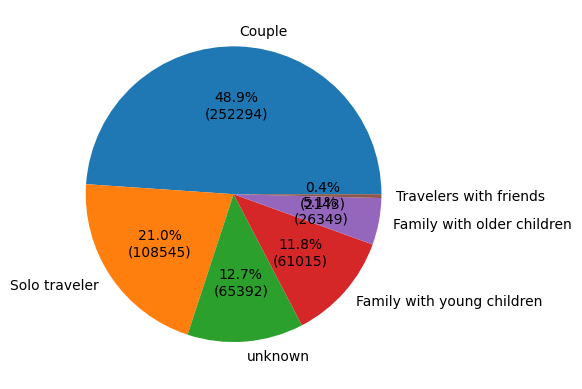

In [391]:
number_of_travalers_tags = ['Couple', 'Solo traveler', 'Family with young children',
                            'Family with older children','Travelers with friends']
def get_number_of_travalers(tags):
    for tag in number_of_travalers_tags:
        if tag in tags:
            return tag
    return 'unknown'


hotels['number_of_travalers']=hotels['tags'].apply(get_number_of_travalers)
pie_data = hotels['number_of_travalers'].value_counts(dropna=False)
plt.pie(x= pie_data, labels=pie_data.index,autopct=autopct_format(pie_data));

In [392]:
# hotels['number_of_travalers'].fillna(hotels['number_of_travalers'].mode()[0],inplace=True)
hotels = pd.get_dummies(hotels, columns=['number_of_travalers'])

In [393]:
hotels.filter(like='number_of_travalers').value_counts()

number_of_travalers_Couple  number_of_travalers_Family with older children  number_of_travalers_Family with young children  number_of_travalers_Solo traveler  number_of_travalers_Travelers with friends  number_of_travalers_unknown
1                           0                                               0                                               0                                  0                                           0                              252294
0                           0                                               0                                               1                                  0                                           0                              108545
                                                                                                                            0                                  0                                           1                               65392
                                              

#### 2.9 Tags. New feature. number_of_nights
Из тагов заполним признак number_of_nights - сколько  
пользователь провел ночей в отеле.

In [394]:
def get_number_of_nights(tags):
    if 'night' in tags.lower():
        return int(tags.split('Stayed ')[1].split()[0])
    return np.nan

hotels['number_of_nights'] = hotels.tags.apply(get_number_of_nights)


In [395]:
hotels['number_of_nights'].fillna(hotels['number_of_nights'].mode()[0],inplace=True)

#### 2.10 Tags. New feature. Device

In [396]:
def get_device(tags):
    if 'submitted from a mobile device' in tags.lower():
        return 'mobile'
    return 'not mobile'

In [397]:
hotels['device'] = hotels.tags.apply(get_device)
hotels = pd.get_dummies(hotels, columns=['device'])

In [398]:
hotels.filter(like = 'device').value_counts()

device_mobile  device_not mobile
1              0                    307640
0              1                    208098
dtype: int64

#### 2.12 days_since_review

In [399]:
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x:int(x.split()[0]))

### 3. Нормализация непрерывных признаков

In [400]:
mm_scaler = preprocessing.MinMaxScaler()
r_scaler = preprocessing.RobustScaler()

number_features = ['additional_number_of_scoring','average_score',
                   'review_total_positive_word_counts','total_number_of_reviews',
                   'review_total_negative_word_counts','total_number_of_reviews_reviewer_has_given',
                   'lat','lng','number_of_nights','days_since_review']


# hotels_scaled = mm_scaler.fit_transform(hotels[number_features])
hotels_scaled = r_scaler.fit_transform(hotels[number_features])

hotels[number_features] = pd.DataFrame(hotels_scaled)

### 4. Удаление признаков

In [401]:
columns_to_drop = [s for s in hotels.columns if hotels[s].dtypes == 'object']
additional_columns = ['review_date']
# columns_to_drop.append()
[columns_to_drop.append(item) for item in additional_columns]
hotels.drop(columns=columns_to_drop,inplace=True,errors='ignore',axis=1)

### 5. Оценка значимости признаков 

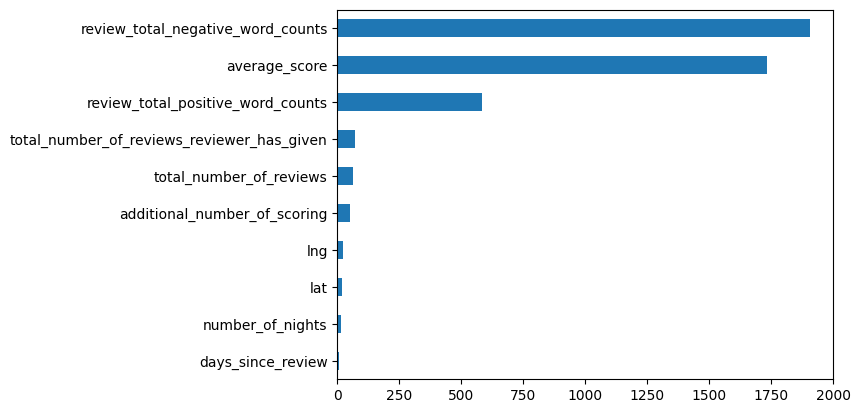

In [415]:
X_selector = hotels[:train_size]
# y определили в 0-вом пункте

num_cols = number_features

from sklearn.feature_selection import f_classif,SelectKBest # anova

imp_num = pd.Series(f_classif(X_selector[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

selector = SelectKBest(f_classif, k=3)
selector.fit(X_selector[num_cols], y)
#Индексы колонок с непрерывными признаками, которые мы оставим
col_idx_num = selector.get_support(indices=True)


array([ 1,  2,  4,  0,  2,  4,  5,  7,  8, 12, 13, 14, 15, 18, 20, 22, 23,
       24, 30, 31, 35, 38, 39])

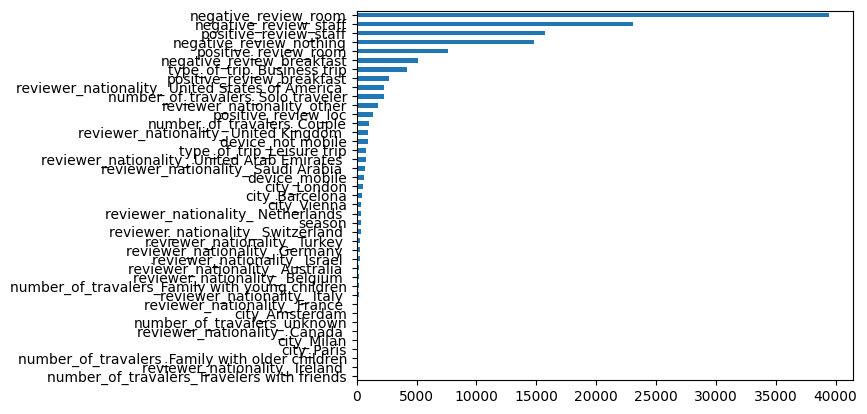

In [423]:
from sklearn.feature_selection import chi2,SelectKBest # хи-квадрат
cat_cols = list(set(X.columns).difference(num_cols))
y_chi2=y.astype('int')

imp_cat = pd.Series(chi2(X[cat_cols], y_chi2)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

selector = SelectKBest(chi2, k=20)
selector.fit(X_selector[cat_cols], y_chi2)
#Индексы колонок с категориальными признаками, которые мы оставим
col_idx_cat = selector.get_support(indices=True)


In [424]:
col_idx = np.concatenate((col_idx_num,col_idx_cat),axis=0)
X = hotels.iloc[:,col_idx] # тут будут train+test датасеты

####

### 6. Обучение модели

In [425]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [427]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X[:train_size], y, test_size=0.25, random_state=42)

In [428]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)


In [431]:
submission_df = pd.read_csv(INPUT_DIR+'submission.csv')
X_test = X[train_size:]
y_submission = regr.predict(X_test)

In [436]:
submission_df['reviewer_score'] = y_submission
submission_df.to_csv('submission.csv',header=True,index=False)

In [429]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.13629874651675808
